## Preprocessing

### Read

In [1]:
import pandas as pd
import re
import json
import numpy as np

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from tqdm.auto import tqdm

import torch
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

from ordered_set import OrderedSet

c:\Users\Ilgar\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_first_n_lines(file_path, n=10000):
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i >= n:
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

# Pfad zu Ihrer JSON-Datei
file_path = 'data/arxiv-metadata-oai-snapshot.json'

# DataFrame erstellen
df = read_first_n_lines(file_path, 10000)


In [3]:
df.dtypes

id                object
submitter         object
authors           object
title             object
comments          object
journal-ref       object
doi               object
report-no         object
categories        object
license           object
abstract          object
versions          object
update_date       object
authors_parsed    object
dtype: object

In [4]:
df.head()

id           submitter  \
0  0704.0001      Pavel Nadolsky   
1  0704.0002        Louis Theran   
2  0704.0003         Hongjun Pan   
3  0704.0004        David Callan   
4  0704.0005  Alberto Torchinsky   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   
3                                       David Callan   
4           Wael Abu-Shammala and Alberto Torchinsky   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   
3  A determinant of Stirling cycle numbers counts...   
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                  comments  \
0  37 pages, 15 figures; published version   
1    To appear in Graphs and Combinatorics   
2                      23 pages, 3 figures   
3                                 11 pages   
4                                     None   

                                 journal-ref                         doi  \
0                   Phys.Rev.D76:013009,2007  10.1103/PhysRevD.76.013009   
1                                       None                        None   
2                                       None                        None   
3                                       None                        None   
4  Illinois J. Math. 52 (2008) no.2, 681-689                        None   

          report-no       categories  \
0  ANL-HEP-PR-07-12           hep-ph   
1              None    math.CO cs.CG   
2              None   physics.gen-ph   
3              None          math.CO   
4              None  math.CA math.FA   

                                             license  \
0                                               None   
1  http://arxiv.org/licenses/nonexclusive-distrib...   
2                                               None   
3                                               None   
4                                               None   

                                            abstract  \
0    A fully differential calculation in perturba...   
1    We describe a new algorithm, the $(k,\ell)$-...   
2    The evolution of Earth-Moon system is descri...   
3    We show that a determinant of Stirling cycle...   
4    In this paper we show how to compute the $\L...   

                                            versions update_date  \
0  [{'version': 'v1', 'created': 'Mon, 2 Apr 2007...  2008-11-26   
1  [{'version': 'v1', 'created': 'Sat, 31 Mar 200...  2008-12-13   
2  [{'version': 'v1', 'created': 'Sun, 1 Apr 2007...  2008-01-13   
3  [{'version': 'v1', 'created': 'Sat, 31 Mar 200...  2007-05-23   
4  [{'version': 'v1', 'created': 'Mon, 2 Apr 2007...  2013-10-15   

                                      authors_parsed  
0  [[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...  
1           [[Streinu, Ileana, ], [Theran, Louis, ]]  
2                                 [[Pan, Hongjun, ]]  
3                                [[Callan, David, ]]  
4  [[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]

### Transform columns

In [5]:
# extract number of pages from string: e.g. "37 pages, 15 figures; published version"

def extract_pages(s):
    match = re.search(r"(\d+)\s*pages", s)
    if match:
        return int(match.group(1))
    else:
        return None

In [6]:
# format columns to right format and extract information

df['authors_parsed'] = df['authors_parsed'].apply(lambda x: [" ".join(i).strip() for i in (eval(x) if isinstance(x, str) else x)]) # authors to name, first name and list
df['versions'] = df['versions'].apply(lambda x: eval(x)[0]["created"] if isinstance(x, str) else x) # first version / created
df['timestamp'] = df['versions'].apply(lambda x: x[0]['created'] if isinstance(x, list) and len(x) > 0 else None)
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%a, %d %b %Y %H:%M:%S %Z", errors='coerce')
df["categories"] = df["categories"].apply(lambda x: x.split(" ")) # sdeperate categories by comma
df.drop(columns=["submitter", "versions", "update_date", "authors"], inplace=True)
df["pages"] = df.comments.apply(lambda x: extract_pages(str(x))) # extract page number
df.head()

id                                              title  \
0  0704.0001  Calculation of prompt diphoton production cros...   
1  0704.0002           Sparsity-certifying Graph Decompositions   
2  0704.0003  The evolution of the Earth-Moon system based o...   
3  0704.0004  A determinant of Stirling cycle numbers counts...   
4  0704.0005  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                  comments  \
0  37 pages, 15 figures; published version   
1    To appear in Graphs and Combinatorics   
2                      23 pages, 3 figures   
3                                 11 pages   
4                                     None   

                                 journal-ref                         doi  \
0                   Phys.Rev.D76:013009,2007  10.1103/PhysRevD.76.013009   
1                                       None                        None   
2                                       None                        None   
3                                       None                        None   
4  Illinois J. Math. 52 (2008) no.2, 681-689                        None   

          report-no          categories  \
0  ANL-HEP-PR-07-12            [hep-ph]   
1              None    [math.CO, cs.CG]   
2              None    [physics.gen-ph]   
3              None           [math.CO]   
4              None  [math.CA, math.FA]   

                                             license  \
0                                               None   
1  http://arxiv.org/licenses/nonexclusive-distrib...   
2                                               None   
3                                               None   
4                                               None   

                                            abstract  \
0    A fully differential calculation in perturba...   
1    We describe a new algorithm, the $(k,\ell)$-...   
2    The evolution of Earth-Moon system is descri...   
3    We show that a determinant of Stirling cycle...   
4    In this paper we show how to compute the $\L...   

                                      authors_parsed  \
0  [Balázs C., Berger E. L., Nadolsky P. M., Yuan...   
1                     [Streinu Ileana, Theran Louis]   
2                                      [Pan Hongjun]   
3                                     [Callan David]   
4            [Abu-Shammala Wael, Torchinsky Alberto]   

                  timestamp  pages  
0 2007-04-02 19:18:42+00:00   37.0  
1 2007-03-31 02:26:18+00:00    NaN  
2 2007-04-01 20:46:54+00:00   23.0  
3 2007-03-31 03:16:14+00:00   11.0  
4 2007-04-02 18:09:58+00:00    NaN

### Define size of dataset

In [7]:
df_short = df.drop_duplicates(subset='title', keep='first')
df_short = df_short.reset_index(drop=True)

### Lemmatization

In [8]:
nlp = spacy.load("en_core_web_sm")

def lemm(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

In [9]:
nlp = spacy.load("en_core_web_sm")
def lemma(docs=df.abstract):
    pip = nlp.pipe(docs, batch_size=32, n_process=-1, disable=["parser", "ner"])
    return [
        [tok.lemma_.lower() for tok in doc if not tok.is_punct and not tok.is_space]
        for doc in tqdm(pip, total=len(docs))
    ]

all_words = lemma(df_short["abstract"])
all_title_words = lemma(df_short["title"])

100%|██████████| 9998/9998 [01:00<00:00, 165.98it/s] 


In [10]:
# create lists that contain lemmatized words from abstracts, titles, and lists of authors and categories for each entry in the DataFrame

all_authors, all_categories= [], []

for index, row in df_short.iterrows():
    text = row['abstract']
    title = row['title']
    author = row['authors_parsed']
    category = row['categories'] 
    all_authors.append(author)
    all_categories.append(category)

print(all_authors)
print(all_categories)

[['Balázs C.', 'Berger E. L.', 'Nadolsky P. M.', 'Yuan C. -P.'], ['Streinu Ileana', 'Theran Louis'], ['Pan Hongjun'], ['Callan David'], ['Abu-Shammala Wael', 'Torchinsky Alberto'], ['Pong Y. H.', 'Law C. K.'], ['Corichi Alejandro', 'Vukasinac Tatjana', 'Zapata Jose A.'], ['Swift Damian C.'], ['Harvey Paul', 'Merin Bruno', 'Huard Tracy L.', 'Rebull Luisa M.', 'Chapman Nicholas', 'Evans Neal J. II', 'Myers Philip C.'], ['Ovchinnikov Sergei'], ['Cunningham Clifton', 'Dembele Lassina'], ['Choi Dohoon'], ['Choi Dohoon', 'Choie YoungJu'], ['Fujii Koichi'], ['Stahn Christian'], ['Chang Chao-Hsi', 'Li Tong', 'Li Xue-Qian', 'Wang Yu-Ming'], ['Mhlahlo Nceba', 'Buckley David H.', 'Dhillon Vikram S.', 'Potter Steven B.', 'Warner Brian', 'Woudt Patric A.'], ['Gustavsson Andreas'], ['Konno Norio'], ['The BABAR Collaboration', 'Aubert B.'], ['Casagrande Vanessa', 'Togashi Yuichi', 'Mikhailov Alexander S.'], ['Malham Simon J. A.', 'Wiese Anke'], ['Loukitcheva M. A.', 'Solanki S. K.', 'White S.'], ['Se

### Delete Stopwords

In [11]:
nltk.download('stopwords')

# Laden der Stoppwörter
stop_words = set(stopwords.words('english'))

# Entfernen der Stoppwörter aus jedem Dokument
filtered_all_words = []
filtered_title_words = []

for words in all_words:
    filtered_words = [word for word in words if word not in stop_words]
    filtered_all_words.append(filtered_words)

for words in all_title_words:
    filtered_words = [word for word in words if word not in stop_words]
    filtered_title_words.append(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ilgar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### List with every word

In [12]:
# create lists with every value without double lists

words_values = [word for sublist in filtered_all_words for word in sublist]

print(words_values)

authors_values = [author for sublist in all_authors for author in sublist]

categories_values = [category for sublist in all_categories for category in sublist]

title_values = [title for sublist in all_title_words for title in sublist]

['fully', 'differential', 'calculation', 'perturbative', 'quantum', 'chromodynamic', 'present', 'production', 'massive', 'photon', 'pair', 'hadron', 'collider', 'next', 'lead', 'order', 'perturbative', 'contribution', 'quark', 'antiquark', 'gluon-(anti)quark', 'gluon', 'gluon', 'subprocesse', 'include', 'well', 'order', 'resummation', 'initial', 'state', 'gluon', 'radiation', 'valid', 'next', 'next', 'lead', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specify', 'calculation', 'reliable', 'good', 'agreement', 'demonstrate', 'datum', 'fermilab', 'tevatron', 'prediction', 'make', 'detailed', 'test', 'cdf', 'datum', 'prediction', 'show', 'distribution', 'diphoton', 'pair', 'produce', 'energy', 'large', 'hadron', 'collider', 'lhc', 'distribution', 'diphoton', 'pair', 'decay', 'higgs', 'boson', 'contrast', 'produce', 'qcd', 'process', 'lhc', 'show', 'enhance', 'sensitivity', 'signal', 'obtain', 'judicious', 'selection', 'event', 'describe', 'new', 'algorithm', '$', 'k,\\ell)$-peb

### Delete duplicates

In [13]:
categories_list = OrderedSet(categories_values)
authors_list = OrderedSet(authors_values)
title_words_list = OrderedSet(title_values)
words_list = OrderedSet(words_values)

### Liste mit allen Attributen erstellen

In [14]:
licenses_list = df_short['license'].tolist()

doi_list = df_short['doi'].tolist()

title_list = df_short['title'].tolist()

comment_list = df_short['comments'].tolist()

journal_list = df_short['journal-ref'].tolist()
journal_list_set = set(journal_list)

words_in_title_list = df_short['title'].tolist()

date_list = df_short['timestamp'].tolist()

id_list = df_short['id'].tolist()

pages_list = df_short['pages'].tolist()

## Create Hetero Object

In [15]:
data = HeteroData()
data['paper'].num_nodes = len(df_short)
data['paper'].license = licenses_list
data['paper'].doi = doi_list
# data['paper'].title = title_list
data['paper'].pages = pages_list
data['paper'].journal = journal_list
data['paper'].date = date_list
data['paper'].id = id_list

data['author'].num_nodes = len(authors_list)
# data['author'].name = authors_list

data['category'].num_nodes = len(categories_list)
# data['category'].name = categories_list

data['journal'].num_nodes = len(journal_list_set)
# data['journal'].name = journal_list

data['word'].num_nodes = len(words_list)
# data['word'].name = words_list

data

HeteroData(
  paper={
    num_nodes=9998,
    license=[9998],
    doi=[9998],
    pages=[9998],
    journal=[9998],
    date=[9998],
    id=[9998],
  },
  author={ num_nodes=25304 },
  category={ num_nodes=142 },
  journal={ num_nodes=5424 },
  word={ num_nodes=41147 }
)

### Create edges

In [16]:
# edge paper written by author
unique_titles = df_short['title'].unique()
title_to_id = {title:i for i, title in enumerate(unique_titles)}
id_to_paper = {i:title for i, title in enumerate(unique_titles)}


idtitle = df_short['title'].apply(lambda x: title_to_id[x])


author_to_id = {author:i for i, author in enumerate(authors_list)}
id_to_author = {i:author for i, author in enumerate(authors_list)}

data['paper'].title = [id_to_paper[i] for i in range(len(id_to_paper))]
data['author'].name = [id_to_author[i] for i in range(len(id_to_author))]

authors_in_paper = [[author_to_id[author] for author in authors] for authors in all_authors]

edge1 = [[paper_id, author_id] for paper_id, author_list in zip(idtitle, authors_in_paper) for author_id in author_list]
edge1 = torch.tensor(edge1).T

data['paper', 'written_by', 'author'].edge_index = edge1

# edge paper has category
category_to_id = {category:i for i, category in enumerate(categories_list)}
id_to_category = {i:category for i, category in enumerate(categories_list)}

data['category'].name = [id_to_category[i] for i in range(len(id_to_category))]

categories_in_paper = [[category_to_id[category] for category in categories] for categories in all_categories]

edge2 = [[paper_id, category_id] for paper_id, category_list in zip(idtitle, categories_in_paper) for category_id in category_list]
edge2 = torch.tensor(edge2).T

data['paper', 'has_category', 'category'].edge_index = edge2

# edge paper has word word
all_words = words_list.union(title_words_list)
all_unique_words = OrderedSet(all_words)

word_to_id = {word:i for i, word in enumerate(all_unique_words)}
id_to_word = {i:word for i, word in enumerate(all_unique_words)}

data['word'].name = [id_to_word[i] for i in range(len(id_to_word))]

words_in_paper = [[word_to_id[word] for word in words] for words in filtered_all_words]	

edge3 = [[paper_id, word_id] for paper_id, word_list in zip(idtitle, words_in_paper) for word_id in word_list]
edge3 = torch.tensor(edge3).T

data['paper', 'has_word', 'word'].edge_index = edge3

# edge paper has titleword word
words_in_title = [[word_to_id[word] for word in title] for title in filtered_title_words] 

edge4 = [[paper_id, word_id] for paper_id, word_list in zip(idtitle, words_in_title) for word_id in word_list]
edge4 = torch.tensor(edge4).T 

data['paper', 'has_titleword', 'word'].edge_index = edge4

# edge paper has journal journal

all_unique_journals = OrderedSet(journal_list)

journal_to_id = {journal:i for i, journal in enumerate(all_unique_journals)}
id_to_journal = {i:journal for i, journal in enumerate(all_unique_journals)}

data['journal'].name = [id_to_journal[i] for i in range(len(id_to_journal))]

journal_in_paper = [journal_to_id[journal] if journal in journal_to_id else None for journal in all_unique_journals]

edge5 = [[paper_id, journal_id] for paper_id, journal_id in zip(idtitle, journal_in_paper)]
edge5 = torch.tensor(edge5).T

data['paper', 'in_journal', 'journal-ref'].edge_index = edge5


In [17]:
data

HeteroData(
  paper={
    num_nodes=9998,
    license=[9998],
    doi=[9998],
    pages=[9998],
    journal=[9998],
    date=[9998],
    id=[9998],
    title=[9998],
  },
  author={
    num_nodes=25304,
    name=[25304],
  },
  category={
    num_nodes=142,
    name=[142],
  },
  journal={
    num_nodes=5424,
    name=[5424],
  },
  word={
    num_nodes=41147,
    name=[42972],
  },
  (paper, written_by, author)={ edge_index=[2, 31363] },
  (paper, has_category, category)={ edge_index=[2, 15059] },
  (paper, has_word, word)={ edge_index=[2, 774949] },
  (paper, has_titleword, word)={ edge_index=[2, 74409] },
  (paper, in_journal, journal-ref)={ edge_index=[2, 5424] }
)

### Assign weights

#### tf-idf: doc-word

In [18]:
# https://medium.com/analytics-vidhya/demonstrating-calculation-of-tf-idf-from-sklearn-4f9526e7e78b

In [19]:
id_to_paper = {}
id_to_word = {}

# creates mapping in order
word_id = 0

# Iteriere durch die Zeilen des DataFrames
for i, words in enumerate(filtered_all_words):
    paper_title = df_short['title'][i]
    if paper_title not in id_to_paper:
        id_to_paper[paper_title] = paper_id
        paper_id += 1

    for word in words:
        if word not in id_to_word:
            id_to_word[word] = word_id
            word_id += 1

NameError: name 'paper_id' is not defined

In [ ]:
# Identitätsfunktion, die als Tokenizer verwendet wird
def identity_tokenizer(text):
    return text

# TF-IDF Vektorizer mit der Identitätsfunktion als Tokenizer
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, vocabulary=id_to_word)

# Angenommen, 'filtered_all_words' ist eine Liste von Listen von Token
tfidf_matrix = vectorizer.fit_transform(filtered_all_words)

# Initialisierung der Kantenliste und der TF-IDF-Gewichte
edge_index_list_has_word = [[], []]
tfidf_weights = []

# Extraktion der TF-IDF-Werte und Erstellung der Kanten
for i in range(len(df_short)):
    paper_title = df_short['title'][i]
    paper_idx = id_to_paper[paper_title]

    words = filtered_all_words[i]
    for word in words:
        if word in id_to_word:
            word_idx = id_to_word[word]
            tfidf_weight = tfidf_matrix[i, id_to_word[word]] # FEHLER HIER

            if tfidf_weight:  # Fügen Sie nur Kanten für positive TF-IDF-Werte hinzu
                edge_index_list_has_word[0].append(paper_idx)
                edge_index_list_has_word[1].append(word_idx)
                tfidf_weights.append(tfidf_weight)

# Konvertiere die Listen in torch.Tensor-Objekte
edge_index_tensor_has_word = torch.tensor(edge_index_list_has_word, dtype=torch.long)
tfidf_weights_tensor = torch.tensor(tfidf_weights, dtype=torch.float)

# Weise die Edge-Indizes und -Attribute dem HeteroData-Objekt zu
data['paper', 'has_word', 'word'].edge_index = edge_index_tensor_has_word
data['paper', 'has_word', 'word'].edge_attr = tfidf_weights_tensor

c:\Users\Ilgar\anaconda3\envs\NLP\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Axes: >

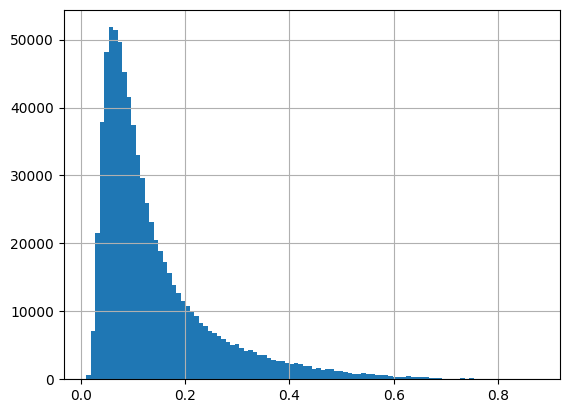

In [ ]:
tfidf_df = pd.DataFrame({
    'tfidf_weight': tfidf_weights
})
tfidf_df.tfidf_weight.hist(bins=100)

#### PMI: word-word

In [ ]:
# https://www.listendata.com/2022/06/pointwise-mutual-information-pmi.html

In [ ]:
tokens = [item for sublist in filtered_all_words for item in sublist]

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens, window_size=10)

# Initialisieren der Kanten und PMI-Werte
edge_index = [[], []]

# Berechnen der NPMI-Werte
npmi_values = []

for bigram, pmi_score in finder.score_ngrams(bigram_measures.pmi):
    if pmi_score > 0: # instead of npmi > 0
        word1, word2 = bigram

        # calculate normalization
        pxy = finder.ngram_fd[bigram] / finder.N # Berechnen der gemeinsamen Wahrscheinlichkeit p(x, y)
        npmi = pmi_score / -np.log2(pxy) # formula
        # print(f"{finder.ngram_fd[bigram]}, {finder.N}, {pmi_score}, {npmi}")

        # Hinzufügen der berechneten NPMI-Werte und Edge-Index zur Liste
        edge_index[0].append(id_to_word[word1])
        edge_index[1].append(id_to_word[word2])
        npmi_values.append(npmi)

# Konvertieren in PyTorch Tensoren
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
npmi_values_tensor = torch.tensor(npmi_values, dtype=torch.float)

# Hinzufügen der Kanten und Kantenattribute zum HeteroData-Objekt
edge_type = ('word', 'co_occurs_with', 'word')

data[edge_type].edge_index = edge_index_tensor
data[edge_type].edge_attr = npmi_values_tensor

<Axes: >

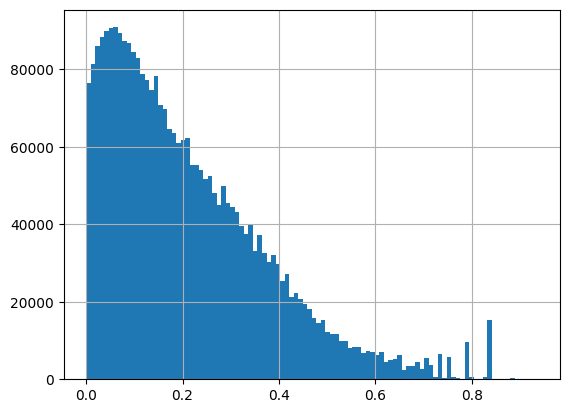

In [ ]:
npmi = pd.DataFrame({"npmi":npmi_values_tensor})
npmi.npmi.hist(bins=100)

In [ ]:
finder.score_ngrams(bigram_measures.pmi)

[((')=(w_{2},w_{3},w_{4}', '\\{0,1'), 16.39381684161605),
 ((')=(w_{2},w_{3},w_{4}', 'n-1\\}$'), 16.39381684161605),
 ((')=(w_{2},w_{3},w_{4}', 'x_{k'), 16.39381684161605),
 ((')d}$', 'th/0606125'), 16.39381684161605),
 (('+0', 'm<1'), 16.39381684161605),
 (('+0', 'r=-rf_{,r}/f'), 16.39381684161605),
 (('+0.012', '-0.010(sys'), 16.39381684161605),
 (('+0.019/-0.012', '+0.012/-0.008'), 16.39381684161605),
 (('+0.019/-0.012', '43;m_r<-20'), 16.39381684161605),
 (('+0.021/-0.014', '+0.66/-0.32'), 16.39381684161605),
 (('+0.021/-0.014', '1.37'), 16.39381684161605),
 (('+0.026/-0.013', '+0.05/-0.06'), 16.39381684161605),
 (('+0.026/-0.013', '-0.17'), 16.39381684161605),
 (('+0.06}_{-0.12', '-0.08})%$'), 16.39381684161605),
 (('+0.06}_{-0.29', '+2}_{-18'), 16.39381684161605),
 (('+0.06}_{-0.29', '+5'), 16.39381684161605),
 (('+0.06}_{-0.29', '-0.03}\\pm0.08'), 16.39381684161605),
 (('+0.06}_{-0.29', '-4})^\\circ$.'), 16.39381684161605),
 (('+0.06}_{-0.29', '\\arg(q'), 16.39381684161605),
 ((

#### Jaccard Similarity for doc-doc

In [ ]:
# https://medium.com/@mayurdhvajsinhjadeja/jaccard-similarity-34e2c15fb524
# https://www.learndatasci.com/glossary/jaccard-similarity/#:~:text=The%20Jaccard%20similarity%20measures%20the,of%20observations%20in%20either%20set.

In [ ]:
# Angenommen, 'documents' ist eine Liste von Listen, wobei jede innere Liste die Wortindizes eines Dokuments enthält
documents = filtered_all_words

# Berechnen Sie die Jaccard-Ähnlichkeit für jedes Dokumentenpaar
doc_edge_index = [[], []]
doc_similarity_values = []

def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

for i in tqdm(range(len(documents)), desc="Calculate Jaccard similarity"):
    for j in range(i + 1, len(documents)):
        similarity = jaccard_set(documents[i], documents[j])
        
        # Fügen Sie die Kanten und Ähnlichkeitswerte hinzu
        doc_edge_index[0].append(i)
        doc_edge_index[1].append(j)
        doc_similarity_values.append(similarity)

# Konvertieren in PyTorch Tensoren
doc_edge_index_tensor = torch.tensor(doc_edge_index, dtype=torch.long)
doc_similarity_values_tensor = torch.tensor(doc_similarity_values, dtype=torch.float)

# Hinzufügen der Kanten und Kantenattribute zum HeteroData-Objekt
doc_edge_type = ('doc', 'similarity', 'doc')
data[doc_edge_type].edge_index = doc_edge_index_tensor
data[doc_edge_type].edge_attr = doc_similarity_values_tensor

Calculate Jaccard similarity:   0%|          | 0/9998 [00:00<?, ?it/s]

Calculate Jaccard similarity:  46%|████▌     | 4592/9998 [02:03<02:25, 37.18it/s]


KeyboardInterrupt: 

<Axes: >

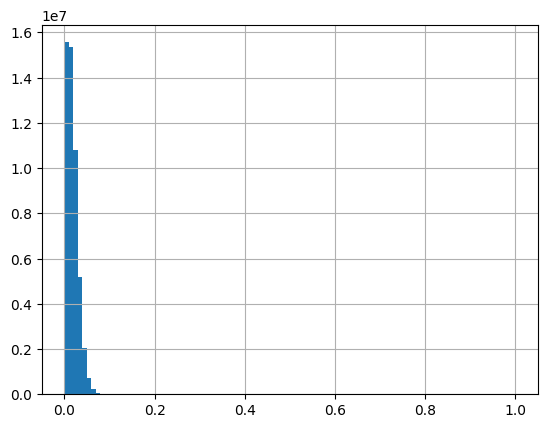

In [ ]:
df_dd = pd.DataFrame({
    "jaccard": doc_similarity_values
})

df_dd.jaccard.hist(bins=100)

In [ ]:
df_dd.jaccard.nlargest(50)

1541119     1.000000
1541209     1.000000
1543138     1.000000
1544002     1.000000
1546507     1.000000
29988089    1.000000
29990018    1.000000
29990882    1.000000
29993387    1.000000
30554903    1.000000
30555767    1.000000
30558272    1.000000
40715810    1.000000
40718315    1.000000
44062427    1.000000
249710      0.842105
1543782     0.750000
29990662    0.750000
30555547    0.750000
40715590    0.750000
43279252    0.750000
43281757    0.750000
4759791     0.735849
20541378    0.687500
7410862     0.661017
33366206    0.642857
42511756    0.635294
41022207    0.629630
44740774    0.628788
10209375    0.625000
49614201    0.615385
33909058    0.614973
1538523     0.600000
10207777    0.600000
10207867    0.600000
10209796    0.600000
10210660    0.600000
10213165    0.600000
43472196    0.600000
48281286    0.600000
41019828    0.590909
30004482    0.576923
21605733    0.568182
42282000    0.565217
38538852    0.561798
17802907    0.557692
49648977    0.554217
22294606    0

In [ ]:
# find duplicate abstracts -> reason for similarity 1.0
non_unique_abstracts = df[df.duplicated('abstract', keep=False)]
non_unique_abstracts

id                                              title  \
25    0704.0026  Placeholder Substructures II: Meta-Fractals, M...   
111   0704.0112  Placeholder Substructures III: A Bit-String-Dr...   
155   0704.0156  Nonlinear force-free coronal magnetic field ex...   
488   0704.0489  Relativistic treatment in D-dimensions to a sp...   
572   0704.0573  Elativistic treatment in}$D$ - Dimensions to a...   
3766  0704.3767             A new proof of the Beez-Cartan theorem   
4235  0705.0233  Coordination for a Group of Autonomous Mobile ...   
4330  0705.0328  The Dynamical State fo the Starless Dense Core...   
4332  0705.0330  The Dynamical State of the Starless Dense Core...   
4405  0705.0403  Tracking control for multi-agent consensus wit...   
5696  0705.1694  Note on Schmidt Decomposition in Infinite Dime...   
6077  0705.2075        Vanishing and injectivity theorems for LMMP   
6078  0705.2076             Notes on the log minimal model program   
6560  0705.2558  Invariance Mechanics - A new direction for qua...   
9065  0706.0379  Giant Magnetoresistive Effect in Colloidal Mag...   
9192  0706.0506  Diffuse Gamma-Rays Produced in Cosmic-Ray Inte...   
9195  0706.0509  Gamma-Rays Produced in Cosmic-Ray Interactions...   

                                               comments  \
25    31 pp. Second of 3-part "theorem/proof" exposi...   
111   32 pp., 1 fig. Third of 3-part "theorem/proof"...   
155   This paper has been withdrawn by the authors. ...   
488                                            20 pages   
572                                            20 pages   
3766                                               None   
4235                                  5 pages,7 figures   
4330           to appear in ApJ vol 665 20 August 2007;   
4332           to appear in ApJ vol 665 20 August 2007;   
4405                                            6 pages   
5696                      This paper has been withdrawn   
6077  v2: introduction was expanded, minor revisions...   
6078  v2: many explanations were added, v3: this pre...   
6560        This paper has been withdrawn by the author   
9065                                               None   
9192  4 pages; 5 figures; Contribution to the 30th I...   
9195  3 pages; 4 figures; Contribution to the First ...   

                             journal-ref                               doi  \
25                                  None                              None   
111                                 None                              None   
155                                 None              10.1029/2007JA012441   
488     Cent. Eur. J. Phys. 6, 141(2008)         10.2478/s11534-008-0018-0   
572                                 None                              None   
3766  Int. Math. For, 2, 2007, 1281-1293                              None   
4235                                None         10.1109/CHICC.2006.280978   
4330        Astrophys.J.665:457-465,2007                    10.1086/519272   
4332                                None                    10.1086/519272   
4405                                None  10.1016/j.automatica.2006.02.013   
5696                                None                              None   
6077                                None                              None   
6078                                None                              None   
6560                                None                              None   
9065                                None                              None   
9192                                None                              None   
9195       AIPConf.Proc.921:169-171,2007                 10.1063/1.2757294   

     report-no                              categories  \
25        None                               [math.RA]   
111       None                               [math.RA]   
155       None                              [astro-ph]   
488       None                              [quant-p

# Export

In [ ]:
# Serialize and save the hetero-object
with open('hetero_graph.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# Load the hetero-object
with open('hetero_graph.pkl', 'rb') as f:
    loaded_hetero_graph = pickle.load(f)
loaded_hetero_graph["author"]

{'num_nodes': 25304, 'name': ['Balázs C.', 'Berger E. L.', 'Nadolsky P. M.', 'Yuan C. -P.', 'Streinu Ileana', 'Theran Louis', 'Pan Hongjun', 'Callan David', 'Abu-Shammala Wael', 'Torchinsky Alberto', 'Pong Y. H.', 'Law C. K.', 'Corichi Alejandro', 'Vukasinac Tatjana', 'Zapata Jose A.', 'Swift Damian C.', 'Harvey Paul', 'Merin Bruno', 'Huard Tracy L.', 'Rebull Luisa M.', 'Chapman Nicholas', 'Evans Neal J. II', 'Myers Philip C.', 'Ovchinnikov Sergei', 'Cunningham Clifton', 'Dembele Lassina', 'Choi Dohoon', 'Choie YoungJu', 'Fujii Koichi', 'Stahn Christian', 'Chang Chao-Hsi', 'Li Tong', 'Li Xue-Qian', 'Wang Yu-Ming', 'Mhlahlo Nceba', 'Buckley David H.', 'Dhillon Vikram S.', 'Potter Steven B.', 'Warner Brian', 'Woudt Patric A.', 'Gustavsson Andreas', 'Konno Norio', 'The BABAR Collaboration', 'Aubert B.', 'Casagrande Vanessa', 'Togashi Yuichi', 'Mikhailov Alexander S.', 'Malham Simon J. A.', 'Wiese Anke', 'Loukitcheva M. A.', 'Solanki S. K.', 'White S.', 'Serga A. A.', 'Kostylev M.', 'Hille